In [2]:
from torch_geometric.data import Data
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random
from torch_geometric.datasets import KarateClub
from utils import create_pointer_graph
import numpy as np

In [18]:
graph = KarateClub().data
graph.num_nodes = graph.num_nodes[0]
pg = create_pointer_graph(graph)

In [21]:
a = set()

In [57]:
def random_walk(node, nsteps):
    s = set()
    s.add(node)
    for step in range(nsteps):
        new = np.random.choice(pg[node][0])
        s.add(new)
        node = new
    return s
walk(0, 3)

{0, 3, 7, 13}

In [72]:
def get_samples(node, nwalks, nsteps=4):
    l = []
    for sample in range(nwalks):
        s = random_walk(node, nsteps)
        for pos_sample in s:
            l.append([node, pos_sample, 1])
        for neg_sample in np.random.choice(list(range(graph.num_nodes)), len(s)):
            l.append([node, neg_sample, 0])
    return torch.tensor(l)

a = get_samples(0, 3)

In [85]:
class Model(nn.Module):
    def __init__(self, emb_dim, num_nodes):
        super().__init__()
        self.emb_dim = emb_dim
        self.emb = nn.Embedding(num_nodes, emb_dim)
    def forward(self, x):
        return self.emb(x)
model = Model(2, graph.num_nodes)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [100]:
for ep in range(1000):
    x1, x2, y = torch.zeros(0, 1).long(), torch.zeros(0, 1).long(), torch.zeros(0, 1).long()
    for node in range(graph.num_nodes):
        ret = get_samples(node, nwalks=2, nsteps=4).unsqueeze(-1)
        x1, x2, y = torch.cat((x1, ret[:, 0])), torch.cat((x1, ret[:, 1])), torch.cat((x1, ret[:, 2]))
    y = y + (1-y)*(-1)
    # loss = F.pairwise_distance(model(x1.squeeze(-1)), model(x2.squeeze(-1)))*y
    loss = F.triplet_margin_loss(0.2, model(x1.squeeze(-1)), model(x2.squeeze(-1)))*y
    loss = loss.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    if ep%20==0:
        print(ep, loss.item())

TypeError: triplet_margin_loss(): argument 'anchor' (position 1) must be Tensor, not float

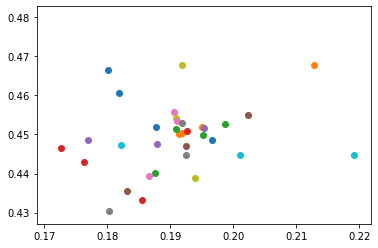

In [97]:
import matplotlib.pyplot as plt
for node in range(graph.num_nodes):
    emb = model(torch.tensor(node))
    x, y = [emb[0].item()], [emb[1].item()]
    plt.scatter(x, y)
plt.show()

In [89]:
model(x1).shape

torch.Size([588, 1, 2])